In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision.transforms import Compose,ToTensor

import numpy as np
import matplotlib.pyplot as plt
import PIL

### Generative Adversarial Networks
#### Generator
- Generates fake images
- Get labels to generates specific images

In [3]:
class Generator(nn.Module):
    def __init__(self,latent_size):
        super(Generator,self).__init__()
        self.latent_size = latent_size

        self.gen_fc1 = nn.Linear(self.latent_size,128)
        self.label_fc = nn.Linear(10,128)
        self.gen_fc2 = nn.Linear(256,512)
        self.gen_fc3 = nn.Linear(512,784)

    def generator(self,label):
        batch_size = label.shape[0]
        z = torch.randn((batch_size,self.latent_size)) # batch size 만큼 노이즈 만듬
        if torch.cuda.is_available():
            z = z.cuda()

        gen = self.gen_fc1(z) # latent_size -> 128
        gen_label = self.label_fc(label) # label -> 128
        gen = torch.cat((gen,gen_label),-1) # (batch_size, 128 + 128)로 만듬
        gen = torch.relu(gen) # (batch_size, 256), 256 -> 256
        gen = self.gen_fc2(gen) # 256 -> 512
        gen = torch.relu(gen) # 512 -> 512
        gen = self.gen_fc3(gen) # 512 -> 786
        img_ = torch.sigmoid(gen).view(-1,1,28,28)
        return img_

    def forward(self,label):
        img = self.generator(label)
        return img

#### Discriminator
- Find fake images

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()

        self.dis_fc1 = nn.Linear(784,512)
        self.dis_fc2 = nn.Linear(512,128)
        self.label_fc = nn.Linear(10,128)
        self.dis_fc3 = nn.Linear(256,32)
        self.dis_fc4 = nn.Linear(32,1)

    def discriminator(self,img,label):
        batch_size = img.shape[0]
        img = img.view(batch_size,-1)

        dis = self.dis_fc1(img) # 784 -> 512
        dis = torch.relu(dis) # 512 -> 512
        dis = self.dis_fc2(dis) # 512 -> 128
        dis = torch.relu(dis) # 128 -> 128
        dis_label = self.label_fc(label) # 10 -> 128
        dis = torch.cat((dis,dis_label),-1) # 128 + 128 -> 256
        dis = self.dis_fc3(dis) # 256 -> 32
        dis = torch.relu(dis) # 32 -> 32
        dis = self.dis_fc4(dis) # 32 -> 1
        dis = torch.sigmoid(dis) # -1 ~ 1
        return dis

    def forward(self,img,label):
        criterion = self.discriminator(img,label)
        return criterion

#### Util functions

In [5]:
def one_hot(x):
    res = torch.zeros((x.shape[0],10))
    for i in range(x.shape[0]):
        res[i,x[i]]=1
    return res

#### Hyperparameters

In [6]:
NUM_EPOCHS = 150
BATCH_SIZE = 128
LATENT_SIZE = 100
LEARNING_RATE = 2e-4
EPS = 1e-6
LEARNING_RATIO = 1

#### Dataloader

In [7]:
transforms = Compose([
    ToTensor(),
])

trainset = MNIST('./',train=True,transform=transforms,download=True)
testset = MNIST('./',train=False,transform=transforms,download=True)

args = {
    'num_workers' : 1,
    'batch_size' : BATCH_SIZE,
    'shuffle' : True,
}

train_loader = DataLoader(trainset,**args)
test_loader = DataLoader(testset,**args)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 3284190.82it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 146576.55it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1478113.99it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1131938.73it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [8]:
len(trainset)

60000

In [9]:
trainset[7][0].shape, trainset[7][0]
# image size 28, 28

(torch.Size([1, 28, 28]),
 tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000

#### Training part

number of parameters(generator) : 548112
number of parameters(discriminator) : 477249
epoch 1
 gen : 1861.40742	 dis : 155.60975


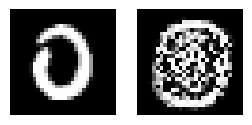

epoch 2
 gen : 2723.67083	 dis : 21.11334


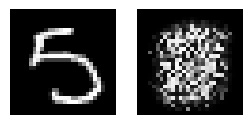

epoch 3
 gen : 2929.81139	 dis : 18.31286


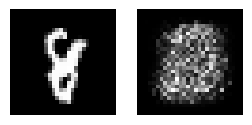

epoch 4
 gen : 2684.82265	 dis : 18.32164


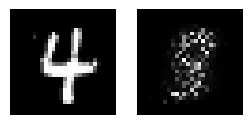

epoch 5
 gen : 3485.04401	 dis : 8.29614


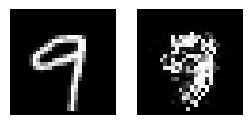

epoch 6
 gen : 3731.55595	 dis : 5.26150


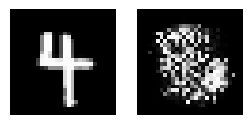

epoch 7
 gen : 3956.83700	 dis : 5.09850


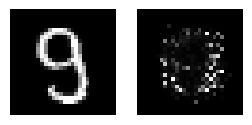

epoch 8
 gen : 3868.96606	 dis : 6.31269


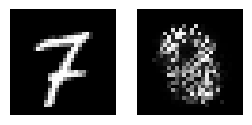

epoch 9
 gen : 4465.20595	 dis : 5.99632


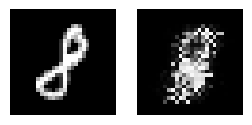

epoch 10
 gen : 4469.94521	 dis : 8.12873


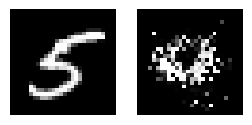

epoch 11
 gen : 4279.02651	 dis : 7.39712


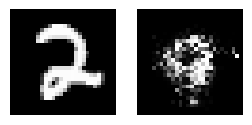

epoch 12
 gen : 3972.77336	 dis : 11.96889


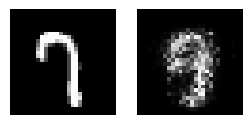

epoch 13
 gen : 4097.82573	 dis : 9.93355


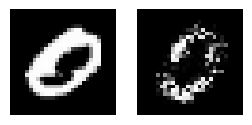

epoch 14
 gen : 4126.92875	 dis : 10.08958


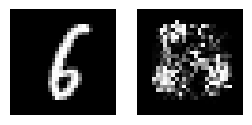

epoch 15
 gen : 4263.53923	 dis : 8.05645


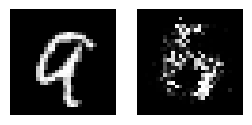

epoch 16
 gen : 4008.97093	 dis : 12.49739


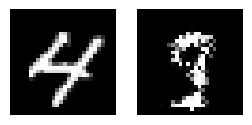

epoch 17
 gen : 3999.58690	 dis : 12.62695


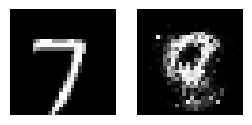

epoch 18
 gen : 3795.15896	 dis : 15.98324


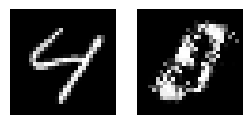

epoch 19
 gen : 3516.80409	 dis : 18.34050


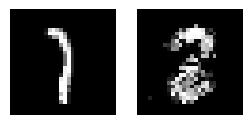

epoch 20
 gen : 3432.78739	 dis : 20.71616


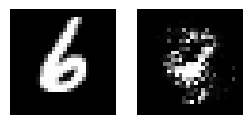

epoch 21
 gen : 3404.66160	 dis : 23.32459


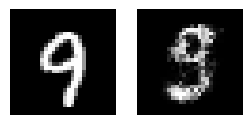

epoch 22
 gen : 3153.64453	 dis : 29.26232


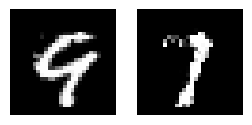

epoch 23
 gen : 3112.08177	 dis : 30.33956


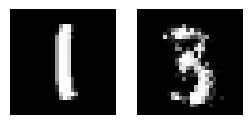

epoch 24
 gen : 3020.83096	 dis : 33.12208


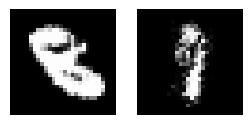

epoch 25
 gen : 2947.19383	 dis : 41.23797


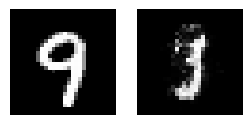

epoch 26
 gen : 2892.77993	 dis : 46.68038


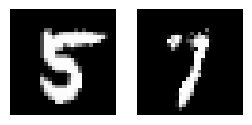

epoch 27
 gen : 2748.85684	 dis : 57.06274


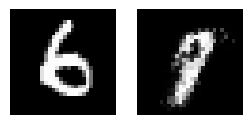

epoch 28
 gen : 2700.04310	 dis : 56.93776


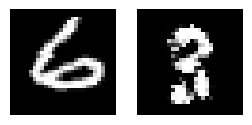

epoch 29
 gen : 2534.54004	 dis : 60.16736


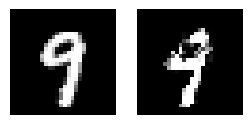

epoch 30
 gen : 2643.06357	 dis : 58.08943


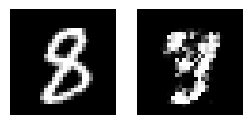

epoch 31
 gen : 2521.94909	 dis : 67.26227


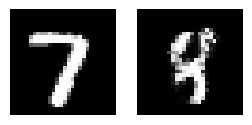

epoch 32
 gen : 2517.47364	 dis : 68.46070


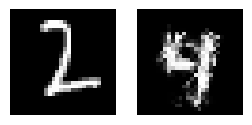

epoch 33
 gen : 2502.39058	 dis : 79.16316


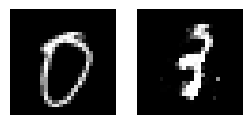

epoch 34
 gen : 2402.51155	 dis : 82.50753


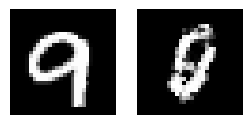

epoch 35
 gen : 2335.62718	 dis : 84.33762


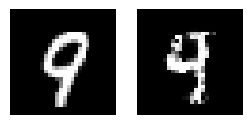

epoch 36
 gen : 2290.20570	 dis : 90.82220


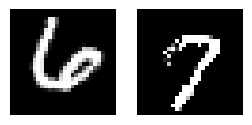

epoch 37
 gen : 2206.98480	 dis : 94.56872


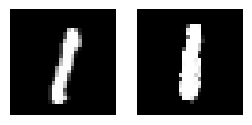

epoch 38
 gen : 2163.91941	 dis : 96.21712


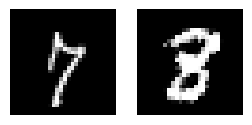

epoch 39
 gen : 2149.28753	 dis : 109.43706


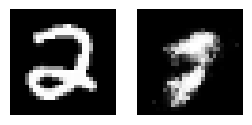

epoch 40
 gen : 2096.01888	 dis : 115.44603


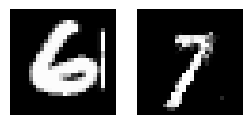

epoch 41
 gen : 2109.03738	 dis : 122.62306


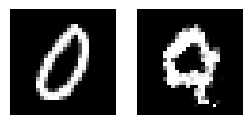

epoch 42
 gen : 2098.15228	 dis : 124.75610


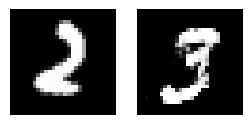

epoch 43
 gen : 2056.72572	 dis : 129.08537


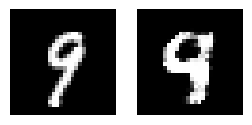

epoch 44
 gen : 2039.10363	 dis : 130.50416


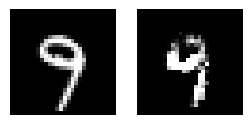

epoch 45
 gen : 2004.97795	 dis : 135.95900


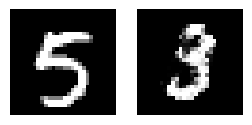

epoch 46
 gen : 1931.35371	 dis : 138.80508


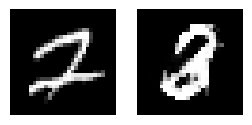

epoch 47
 gen : 1944.12015	 dis : 135.87626


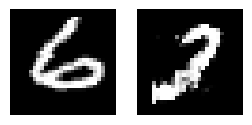

epoch 48
 gen : 1923.77067	 dis : 142.19844


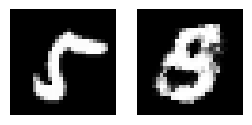

epoch 49
 gen : 1880.46509	 dis : 141.43027


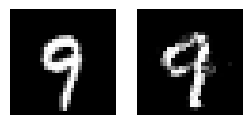

epoch 50
 gen : 1882.41946	 dis : 147.98523


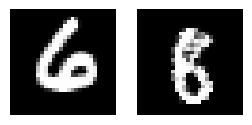

epoch 51
 gen : 1865.88669	 dis : 150.72324


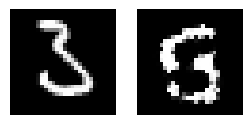

epoch 52
 gen : 1810.87605	 dis : 157.82128


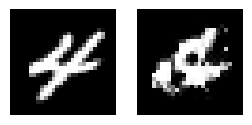

epoch 53
 gen : 1773.92396	 dis : 161.02325


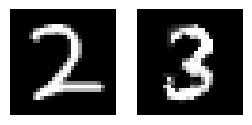

epoch 54
 gen : 1756.07907	 dis : 166.60268


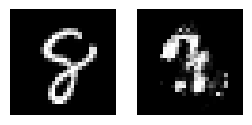

epoch 55
 gen : 1743.09600	 dis : 170.54975


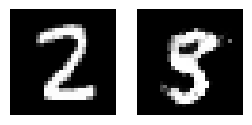

epoch 56
 gen : 1742.72264	 dis : 177.88941


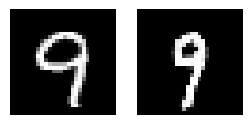

epoch 57
 gen : 1718.98026	 dis : 182.96105


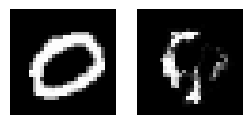

epoch 58
 gen : 1704.73570	 dis : 186.20813


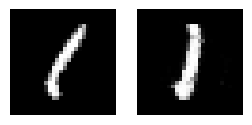

epoch 59
 gen : 1693.32950	 dis : 188.84512


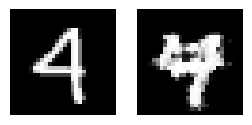

epoch 60
 gen : 1673.50475	 dis : 190.77931


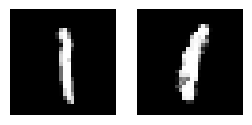

epoch 61
 gen : 1653.27188	 dis : 193.96480


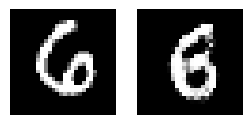

epoch 62
 gen : 1623.68865	 dis : 196.96406


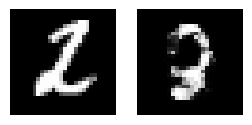

epoch 63
 gen : 1622.09378	 dis : 200.57545


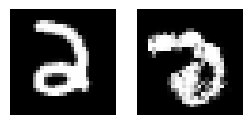

epoch 64
 gen : 1621.81024	 dis : 201.17361


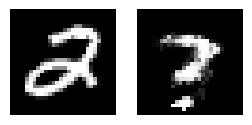

epoch 65
 gen : 1608.99069	 dis : 202.75428


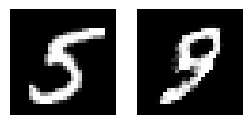

epoch 66
 gen : 1590.28039	 dis : 203.19741


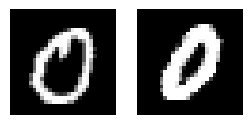

epoch 67
 gen : 1597.40441	 dis : 206.72696


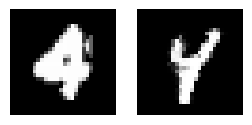

epoch 68
 gen : 1595.98492	 dis : 208.79939


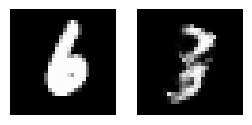

epoch 69
 gen : 1591.08325	 dis : 208.56170


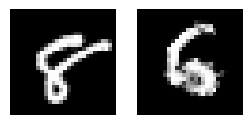

epoch 70
 gen : 1599.28614	 dis : 207.45573


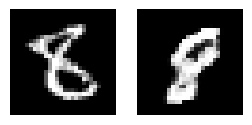

epoch 71
 gen : 1578.99141	 dis : 211.87682


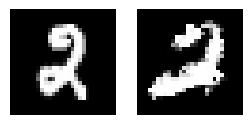

epoch 72
 gen : 1560.26906	 dis : 210.12234


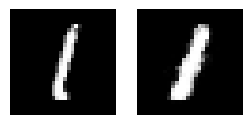

epoch 73
 gen : 1551.21419	 dis : 212.92410


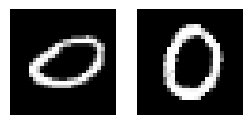

epoch 74
 gen : 1537.76300	 dis : 213.66744


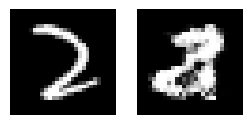

epoch 75
 gen : 1538.93047	 dis : 216.54924


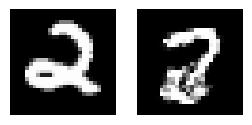

epoch 76
 gen : 1515.00802	 dis : 218.56588


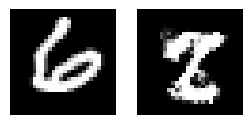

epoch 77
 gen : 1513.19398	 dis : 218.46084


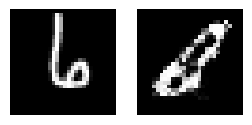

epoch 78
 gen : 1492.20259	 dis : 221.60136


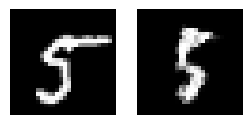

epoch 79
 gen : 1493.21375	 dis : 221.71619


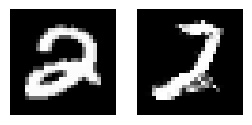

epoch 80
 gen : 1489.71003	 dis : 223.61096


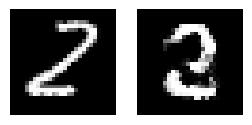

epoch 81
 gen : 1481.95676	 dis : 224.34942


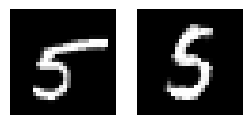

epoch 82
 gen : 1466.27878	 dis : 226.88887


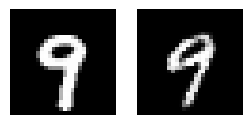

epoch 83
 gen : 1459.69760	 dis : 227.55356


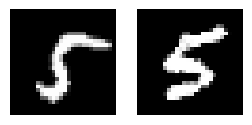

epoch 84
 gen : 1457.10887	 dis : 228.69626


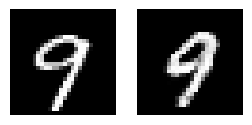

epoch 85
 gen : 1433.14643	 dis : 230.04977


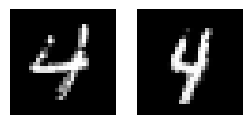

epoch 86
 gen : 1440.00073	 dis : 230.59805


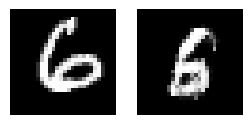

epoch 87
 gen : 1437.48100	 dis : 229.31257


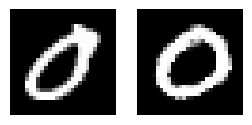

epoch 88
 gen : 1427.07054	 dis : 230.94990


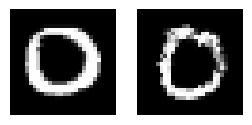

epoch 89
 gen : 1430.10586	 dis : 230.68463


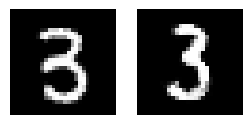

epoch 90
 gen : 1425.91764	 dis : 233.80444


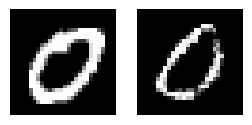

epoch 91
 gen : 1400.00342	 dis : 232.99789


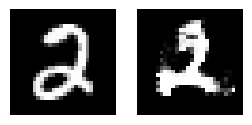

epoch 92
 gen : 1386.92384	 dis : 233.00077


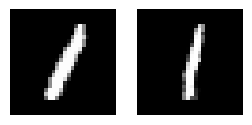

epoch 93
 gen : 1363.23114	 dis : 236.70555


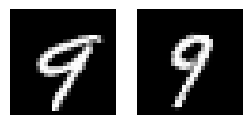

epoch 94
 gen : 1360.56156	 dis : 235.48243


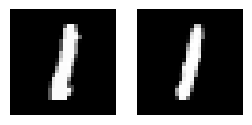

epoch 95
 gen : 1337.98282	 dis : 238.75585


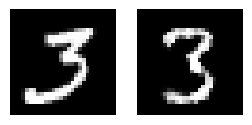

epoch 96
 gen : 1333.44869	 dis : 242.41512


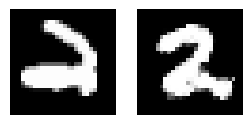

epoch 97
 gen : 1310.49754	 dis : 239.68407


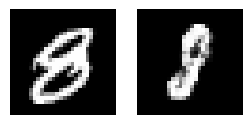

epoch 98
 gen : 1307.73937	 dis : 241.99155


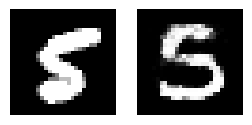

epoch 99
 gen : 1300.68693	 dis : 244.42185


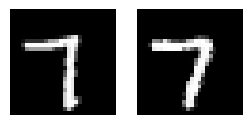

epoch 100
 gen : 1296.45334	 dis : 241.71794


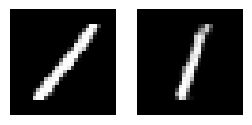

epoch 101
 gen : 1285.11516	 dis : 246.45790


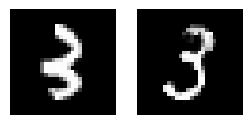

epoch 102
 gen : 1289.19975	 dis : 247.55974


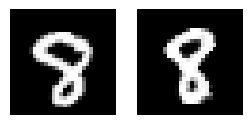

epoch 103
 gen : 1266.70432	 dis : 246.64049


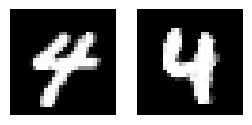

epoch 104
 gen : 1266.26118	 dis : 247.74535


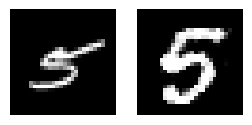

epoch 105
 gen : 1264.76692	 dis : 248.35313


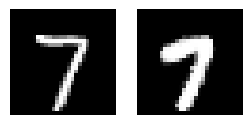

epoch 106
 gen : 1259.85745	 dis : 248.27352


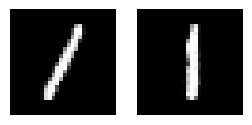

epoch 107
 gen : 1236.21028	 dis : 249.47245


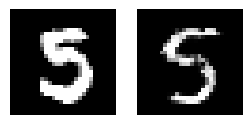

epoch 108
 gen : 1257.39427	 dis : 247.78088


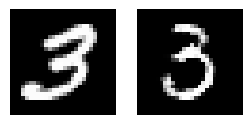

epoch 109
 gen : 1255.29322	 dis : 249.06943


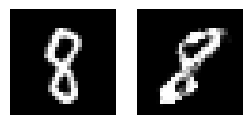

epoch 110
 gen : 1258.17026	 dis : 248.59369


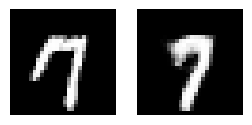

epoch 111
 gen : 1275.68360	 dis : 244.38825


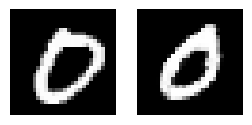

epoch 112
 gen : 1266.37735	 dis : 247.37560


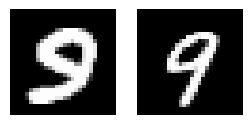

epoch 113
 gen : 1258.54728	 dis : 246.36486


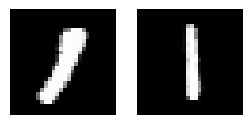

epoch 114
 gen : 1259.77144	 dis : 247.26196


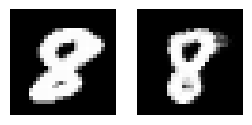

epoch 115
 gen : 1252.44613	 dis : 248.11053


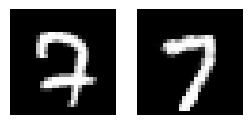

epoch 116
 gen : 1273.40890	 dis : 244.17921


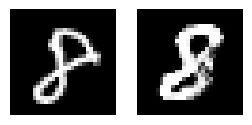

epoch 117
 gen : 1280.55459	 dis : 242.58803


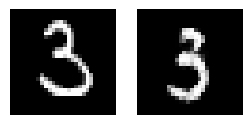

epoch 118
 gen : 1265.61092	 dis : 243.45023


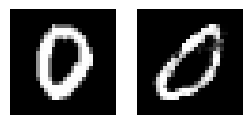

epoch 119
 gen : 1263.69202	 dis : 246.57852


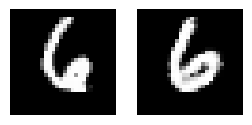

epoch 120
 gen : 1283.85158	 dis : 242.98687


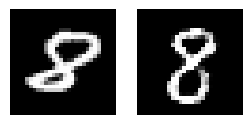

epoch 121
 gen : 1295.04177	 dis : 241.62675


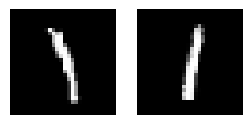

epoch 122
 gen : 1270.89811	 dis : 242.45766


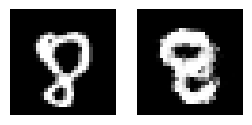

epoch 123
 gen : 1277.47131	 dis : 242.40660


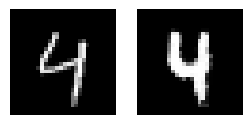

epoch 124
 gen : 1278.07566	 dis : 244.61066


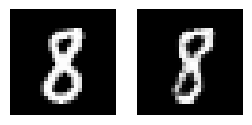

epoch 125
 gen : 1280.05589	 dis : 241.92157


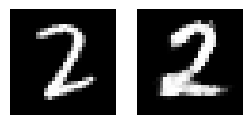

epoch 126
 gen : 1292.22265	 dis : 241.89243


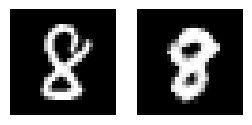

epoch 127
 gen : 1307.70685	 dis : 239.84558


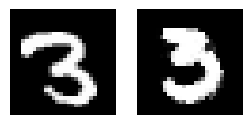

epoch 128
 gen : 1301.28616	 dis : 236.75411


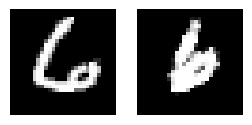

epoch 129
 gen : 1307.66136	 dis : 237.31842


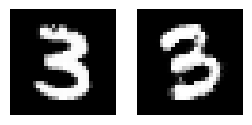

epoch 130
 gen : 1314.65850	 dis : 235.45359


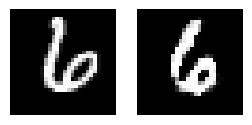

epoch 131
 gen : 1333.27897	 dis : 233.49359


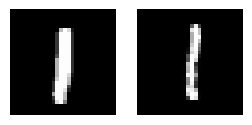

epoch 132
 gen : 1333.26721	 dis : 236.07076


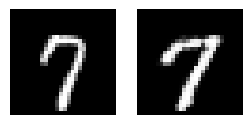

epoch 133
 gen : 1329.97954	 dis : 234.54754


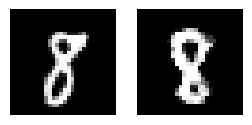

epoch 134
 gen : 1327.25857	 dis : 238.06406


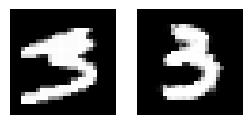

epoch 135
 gen : 1345.06663	 dis : 232.84297


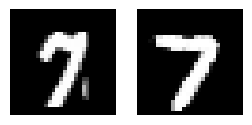

epoch 136
 gen : 1341.69307	 dis : 230.46077


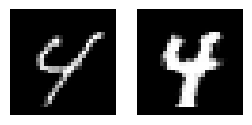

epoch 137
 gen : 1347.59085	 dis : 230.13880


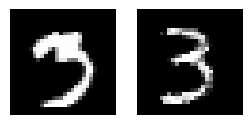

epoch 138
 gen : 1367.55598	 dis : 226.84016


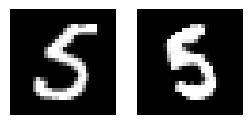

epoch 139
 gen : 1374.09725	 dis : 230.29199


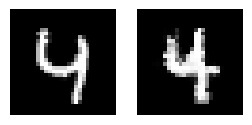

epoch 140
 gen : 1379.38012	 dis : 228.15275


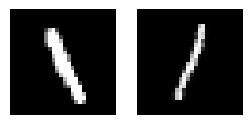

epoch 141
 gen : 1374.23467	 dis : 225.84617


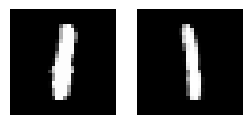

epoch 142
 gen : 1376.56003	 dis : 231.23120


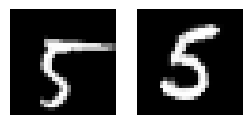

epoch 143
 gen : 1385.07552	 dis : 228.39122


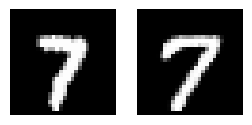

epoch 144
 gen : 1390.50215	 dis : 227.28391


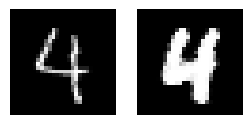

epoch 145
 gen : 1390.83646	 dis : 225.01824


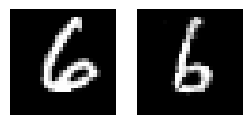

epoch 146
 gen : 1392.11510	 dis : 227.20458


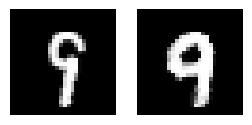

epoch 147
 gen : 1393.15192	 dis : 223.69536


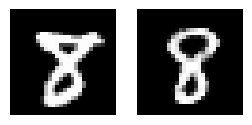

epoch 148
 gen : 1406.93545	 dis : 222.91942


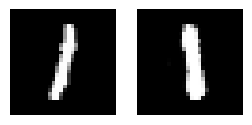

epoch 149
 gen : 1419.27927	 dis : 221.29271


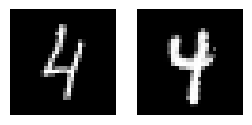

epoch 150
 gen : 1411.68746	 dis : 224.47496


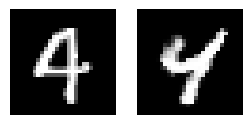

In [10]:
gen = Generator(LATENT_SIZE)
dis = Discriminator()
if torch.cuda.is_available():
    gen = gen.cuda()
    dis = dis.cuda()

gen_parameters = filter(lambda p: p.requires_grad, gen.parameters())
num_params = sum([np.prod(p.size()) for p in gen_parameters])
print("number of parameters(generator) : {}".format(num_params))
dis_parameters = filter(lambda p: p.requires_grad, dis.parameters())
num_params = sum([np.prod(p.size()) for p in dis_parameters])
print("number of parameters(discriminator) : {}".format(num_params))

optimizer_G = Adam(gen.parameters(),lr=LEARNING_RATE)
optimizer_D = Adam(dis.parameters(),lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    tot_gen_loss = 0
    tot_dis_loss = 0
    cnt = 0
    for img,label in train_loader:
        onehot_label = one_hot(label)
        if torch.cuda.is_available():
            img = img.cuda()
            onehot_label = onehot_label.cuda()

        if cnt % LEARNING_RATIO == 0:
            optimizer_D.zero_grad()
            real = dis(img,onehot_label)
            img_ = gen(onehot_label)
            fake = dis(img_,onehot_label)
            dis_loss = -torch.mean(torch.log(real+EPS)+torch.log(1+EPS-fake))
            dis_loss.backward()
            optimizer_D.step()

        optimizer_G.zero_grad()
        img_ = gen(onehot_label)
        fake = dis(img_,onehot_label)
        gen_loss = -torch.mean(torch.log(fake+EPS))
        gen_loss.backward()
        optimizer_G.step()
        tot_dis_loss +=dis_loss.item()
        tot_gen_loss +=gen_loss.item()
        cnt+=1

    print("epoch {}\n gen : {:.5f}\t dis : {:.5f}".format(epoch+1,tot_gen_loss,tot_dis_loss))
    img, label = next(iter(test_loader))
    onehot_label = one_hot(label)
    if torch.cuda.is_available():
        onehot_label = onehot_label.cuda()
    img_ = gen(onehot_label)
    fig = plt.figure(figsize=(3,3))
    fig.add_subplot(1,2,1)
    plt.imshow(img[0].squeeze().numpy(),cmap='gray')
    plt.axis('off')
    img_out = img_[0].squeeze().cpu().detach().numpy()
    fig.add_subplot(1,2,2)
    plt.imshow(img_out,cmap='gray')
    plt.axis('off')
    plt.show()